## Cole Bailey

### cole.bailey@sandiego.edu

# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you
import nltk
from nltk.corpus import brown

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict


from spacy.lang.en.examples import sentences 

nlp = spacy.load("en_core_web_sm")

/Users/colebailey/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/Users/colebailey/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:29: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from tensorflow.python.lib.core import _pywrap_bfloat16
/Users/colebailey/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:511: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any b

In [2]:
#additional
import spacy
import sklearn

In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/colebailey/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [5]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [6]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [7]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

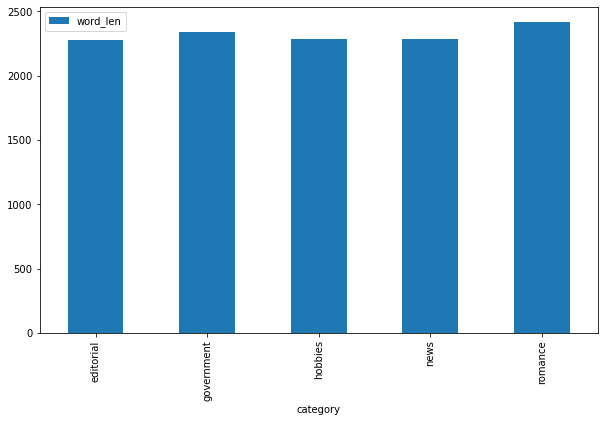

In [8]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [9]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Users/colebailey/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(166, 4941)

In [10]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: TheTFIDF text vectors stems from a bag of word model. It holds the words most relevant to the categories in the corpus. The inverse document frequency can be used to measure the important or unimportance of words in the text. Count text vectors works by one hot encoding the words in the topic. It will then produce a sum of how often the specific word appears in specific topics. Both methods are useful for determining text relevancy.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [11]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/Users/colebailey/opt/anaconda3/lib/python3.8/site-packages/scipy/linalg/decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/Users/colebailey/opt/anaconda3/lib/python3.8/site-packages/scipy/linalg/decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

In [12]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

The NMF topics are mostly similar to the Brown Corpus topics. There are similarities between the topics and the categories created in the DF. By evaluating the top words in the topics, the user can see how one could create categories such as hobbies, government, and news.

In [13]:
# Your code here
#The original categories from the BROWN CORPUS were hobbies,editorial, government, news & romance
#the numbers are the percentage contributions of the words to the respective topic
#If the percentage within a topic is rapidly decreasing, the topic is well-defined, 
##whereas slowly decreasing word probabilities indicate a less-pronounced topic.


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The five topic NMF model focuses on the most frequent/relevant words rather than the individual categories present in the created dataframe. The topics do not seem to be directly tied to the created categories. Topic 00 uses words one could expect to hear in a government category. 'President' and ' Kennedy' directly tie to the U.S government while topic 04 has the most frequent words of 'baseball' and 'game' which could easily fit into the category of hobbies. These topics do not seem to be clearly well defined because of the low frequency of these words as well as the failure of these words to decrease in length rather quickly.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

In [14]:
# Your code here
lsa_text_model = sklearn.decomposition.TruncatedSVD(n_components=5, random_state=314)
W_text_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = lsa_text_model.components_

/Users/colebailey/opt/anaconda3/lib/python3.8/site-packages/scipy/linalg/decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/Users/colebailey/opt/anaconda3/lib/python3.8/site-packages/scipy/linalg/decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model has much more frequency in some of the words. In topic 03, 'mrs' has a 29.45 appearance rate. Many of these words could fit into the original brown corpus categories. Again, there are words that could appear in the government and hobby categories (Kennedy, Khrushchev, baseball...). However, many of these words are incredibly generic and are not in any well defined topic. The low frequency is a strong indicator that these topics are not well defined. There are also no words that appear that the user could confidently place in a romance category. 'mrs' appears in many topics but its hard to understand its high frequency in a topic that also includes 'game' and 'university'

In [15]:
# call display_topics on your model

display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: As shown in the comparison with the brown corpus, there do appear to be issues with the topics being well defined. The extremely high relevance of 'mrs' in topic 03 is confusing since it appears with words such as university game and jr. I'm not sure what name could be given to that topic. However, the words in these topics appear much more frequently with respects to their topics than the words in the NMF model.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [16]:
# Fit your LDA model here
lda_text_model = sklearn.decomposition.LatentDirichletAllocation(n_components=5, random_state=314)
W_text_matrix = lda_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = lda_text_model.components_

In [17]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  plastic (0.02)
  toes (0.02)
  fed (0.02)
  panels (0.02)
  lumber (0.02)

Topic 01
  plastic (0.02)
  toes (0.02)
  fed (0.02)
  panels (0.02)
  lumber (0.02)

Topic 02
  said (0.23)
  mr (0.17)
  state (0.16)
  mrs (0.15)
  president (0.12)

Topic 03
  plastic (0.02)
  toes (0.02)
  fed (0.02)
  panels (0.02)
  lumber (0.02)

Topic 04
  didn (0.17)
  said (0.15)
  ll (0.15)
  thought (0.15)
  looked (0.14)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA model produces the lowest relevance numbers of the three models. Three of the five topics have no words with more than 0.02 percentage contribution to the topic. This is extremely indicative that these topics are poorly defined. There would need to be a sharp dropoff in these numbers to show a well-pronounced topic.


Q: How does your five-topic LDA model compare to the original Brown categories? 

A: The five topics from the LDA model are similar to the Brown categories but not exact. It is difficult to place any of these topics as romance or hobbies. The LDA model also created three topics with the same words. Topic 02 would match the government category as it has the word 'president' but that is about as close as it gets. As far as effectiveness, the LDA was the least effective out of all techniques in matching the Brown Corpus.

In [18]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/Users/colebailey/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [19]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: For each of the topics, the bars displayed on the right indicate how well defined the topic is. For topic 0, the bars decrease in length much quicker than they do in topic 1. This is indicative that topic 0 is much more defined than topic 1. When hovering over the scatterplot on the left, the word frequency in the overall topic is highlighted in red. We can use this in comparison to the above display_topic function to determine the word frequency in both the topics and overall term frequency. The scatterploy does not have any overlap between topics which seems very stange since many words are common english words.
